In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from src.models.model_diff_modular import ModularDiffModel
from src.models.model_diff_adv import AdvDiffModel
from src.models.model_diff_task import TaskDiffModel

In [3]:
output_folder = "charts"

In [4]:
folder = "/share/home/lukash/checkpoints_bert_L4/seed{}"

sparsity_fn = lambda x: round(x[2]/x[0],2)

In [5]:
experiment_name_seed0 = "bert_uncased_L-4_H-256_A-4-fixmask0.1-modular.pt"
experiment_name = "bert_uncased_L-4_H-256_A-4-fixmask0.1-modular-sparse_task.pt"

model_dicts = []
model_layer_dicts = []
model_module_dicts = []
for exp_idx in range(5):
    exp_name = experiment_name_seed0 if exp_idx==0 else experiment_name
    filepath = os.path.join(folder.format(exp_idx), exp_name)
    model = ModularDiffModel.load_checkpoint(filepath)

    model_dict = {}
    for n,m in model.get_encoder_base_modules(return_names=True):
        # n_p, n_p_zero, n_p_one
        model_dict[n] = [model._count_non_zero_params_for_module(m, idx) for idx in range(2)]

    model_module_dict = {}
    unique_modules = set([(x[11:] if x[:10]=="embeddings" else x[16:]) for x in model_dict.keys() if x!="pooler.dense"])
    for module_name in unique_modules:
        for k,v in model_dict.items():
            if k[-len(module_name):] == module_name:
                try:
                    model_module_dict[module_name] += np.array(v)
                except KeyError:
                    model_module_dict[module_name] = np.array(v)
    model_module_dict = {k:[sparsity_fn(v) for v in vals] for k,vals in model_module_dict.items()}
    model_dict = {k:[sparsity_fn(v) for v in vals] for k,vals in model_dict.items()}

    model_dicts.append(model_dict)
    model_module_dicts.append(model_module_dict)

    dicts = [model._count_non_zero_params_per_layer(idx) for idx in range(2)]
    model_layer_dicts.append({k:(sparsity_fn(v0), sparsity_fn(v1)) for (k,v0),v1 in zip(dicts[0].items(), dicts[1].values())})

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing B

In [6]:
modular_layer_dict = {}
for k in model_layer_dicts[0].keys():
    ar = np.array([d[k] for d in model_layer_dicts])
    modular_layer_dict[k] = (ar.mean(0), ar.std(0))

modular_module_dict = {}
for k in model_module_dicts[0].keys():
    ar = np.array([d[k] for d in model_module_dicts])
    modular_module_dict[k] = (ar.mean(0), ar.std(0))

modular_dict = {}
for i in model_dicts[0].keys():
    ar = np.array([d[i] for d in model_dicts])
    modular_dict[i] = (ar.mean(0), ar.std(0))

layer_name = "encoder.layer.{}"
modular_layer_list = []
for i in range(4):
    n = layer_name.format(i)
    layer_dict = {}
    for k, v in modular_dict.items():
        if k[:15] == n:
            layer_dict[k[16:]] = v
    modular_layer_list.append(layer_dict)

modular_emb_dict = {k[11:]:v for k,v in modular_dict.items() if k[:10]=="embeddings"}

In [7]:
experiment_name_task = "bert_uncased_L-4_H-256_A-4-fixmask0.1-task.pt"
experiment_name_adv = "bert_uncased_L-4_H-256_A-4-fixmask0.1-adv.pt"

model_dicts = []
model_layer_dicts = []
model_module_dicts = []
for exp_idx in range(5):
    filepath = os.path.join(folder.format(exp_idx), experiment_name_task)
    model_task = TaskDiffModel.load_checkpoint(filepath)    
    filepath = os.path.join(folder.format(exp_idx), experiment_name_adv)
    model_adv = AdvDiffModel.load_checkpoint(filepath)

    model_dict = {}
    for (n,m_t), m_a in zip(
        model_task.get_encoder_base_modules(return_names=True), 
        model_adv.get_encoder_base_modules()
    ):
        # n_p, n_p_zero, n_p_one
        model_dict[n] = [
            model_task._count_non_zero_params_for_module(m_t), 
            model_adv._count_non_zero_params_for_module(m_a)
        ]

    model_module_dict = {}
    unique_modules = set([(x[11:] if x[:10]=="embeddings" else x[16:]) for x in model_dict.keys() if x!="pooler.dense"])
    for module_name in unique_modules:
        for k,v in model_dict.items():
            if k[-len(module_name):] == module_name:
                try:
                    model_module_dict[module_name] += np.array(v)
                except KeyError:
                    model_module_dict[module_name] = np.array(v)
    model_module_dict = {k:[sparsity_fn(v) for v in vals] for k,vals in model_module_dict.items()}
    model_dict = {k:[sparsity_fn(v) for v in vals] for k,vals in model_dict.items()}

    model_dicts.append(model_dict)
    model_module_dicts.append(model_module_dict)

    dicts = [
        model_task._count_non_zero_params_per_layer(),
        model_adv._count_non_zero_params_per_layer()
    ]
    model_layer_dicts.append({k:(sparsity_fn(v0), sparsity_fn(v1)) for (k,v0),v1 in zip(dicts[0].items(), dicts[1].values())})

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing B

In [8]:
base_layer_dict = {}
for k in model_layer_dicts[0].keys():
    ar = np.array([d[k] for d in model_layer_dicts])
    base_layer_dict[k] = (ar.mean(0), ar.std(0))

base_module_dict = {}
for k in model_module_dicts[0].keys():
    ar = np.array([d[k] for d in model_module_dicts])
    base_module_dict[k] = (ar.mean(0), ar.std(0))

base_dict = {}
for i in model_dicts[0].keys():
    ar = np.array([d[i] for d in model_dicts])
    base_dict[i] = (ar.mean(0), ar.std(0))

layer_name = "encoder.layer.{}"
base_layer_list = []
for i in range(4):
    n = layer_name.format(i)
    layer_dict = {}
    for k, v in base_dict.items():
        if k[:15] == n:
            layer_dict[k[16:]] = v
    base_layer_list.append(layer_dict)

base_emb_dict = {k[11:]:v for k,v in base_dict.items() if k[:10]=="embeddings"}

### Viz

In [9]:
n_layers = len(base_layer_list)
n_layers_adj = n_layers * 2
n_modules = len(base_layer_list[0])
module_names = list(base_layer_list[0].keys())

colors = [plt.get_cmap('Blues'), plt.get_cmap('Oranges')]
color_fn = lambda x: abs(x-1)-0.2

width = 1
spacing = width / 4
y_coords = np.arange(n_layers_adj)
y_coords_adj = np.concatenate([
    y_coords,
    [y_coords[-1] + width, y_coords[-1] + width + spacing*2, y_coords[-1] + width*2 + spacing*2]]
)
y_tick_coords = np.arange(n_layers_adj, step=2) + .5

hline_positions = np.concatenate([
    (y_coords - width/2),
    [y_coords[-1] + width/2, y_coords_adj[-2] - width/2],
    y_coords_adj[-2:] + width/2
])
vline_positions = [0, width*n_modules, width*n_modules+spacing, width*(n_modules+1)+spacing]

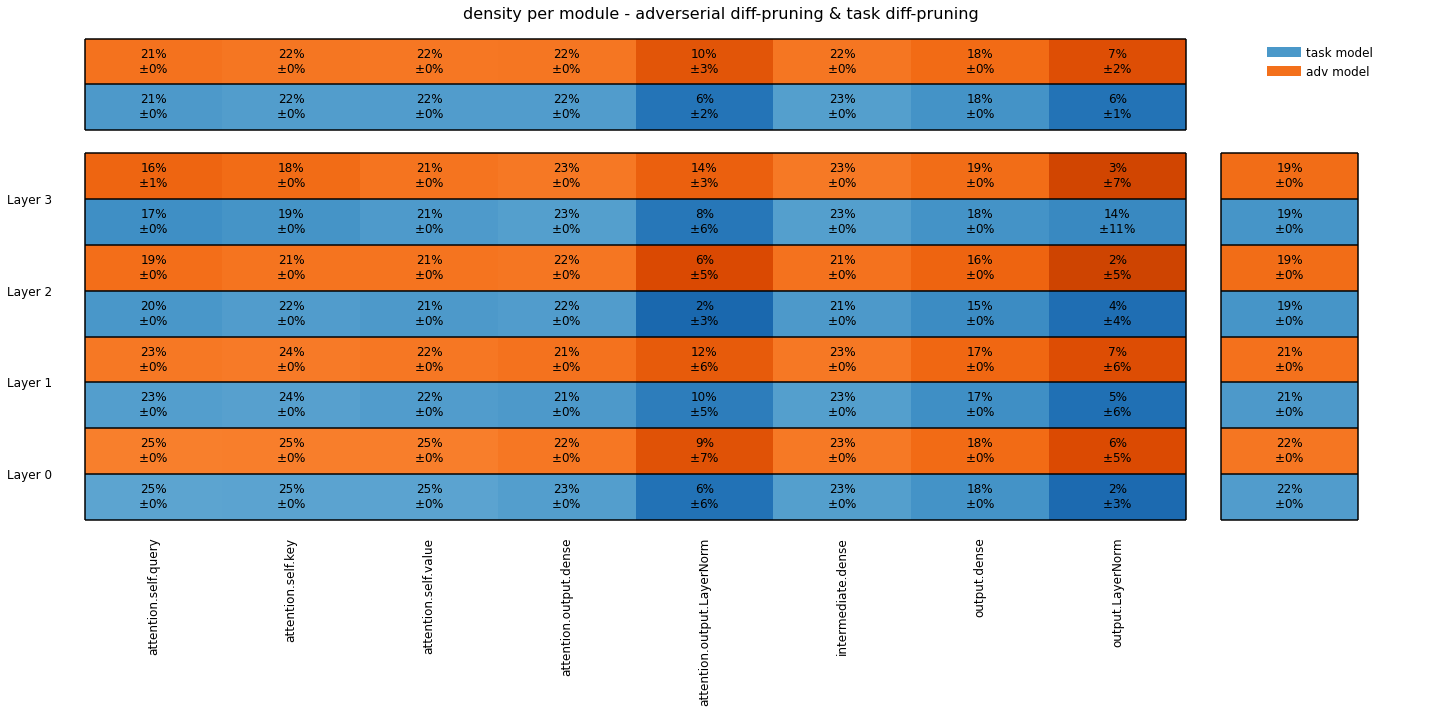

In [10]:
title_fontsize = 16
text_fontsize = 12

plt.figure(figsize=(20,10))
plt.barh(y_coords_adj, width/2, left=0-width/2, height=width, color="w")
start = 0
for m_name in module_names:
    averages, error_margins = [np.stack(x) for x in zip(*[l[m_name] for l in base_layer_list])]
    m_averages, m_error_margins = base_module_dict[m_name]
    color = [c(color_fn(a)) for avgs in averages for c, a in zip(colors, avgs)]

    color.append("w")
    color.extend([c(color_fn(a)) for c,a in zip(colors, m_averages)])

    plt.barh(y_coords_adj, width, height=width, left=start, color=color)
    for y, a, e in zip(y_coords, averages.flatten(), error_margins.flatten()):
        plt.text(start+width/2, y, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    for y, a, e in zip(y_coords_adj[-2:], m_averages, m_error_margins):
        plt.text(start+width/2, y, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

plt.barh(y_coords, spacing, left=start, height=width, color="w")
start += spacing

averages, error_margins = [np.stack(x) for x in zip(*list(base_layer_dict.values())[1:])]
color = [c(color_fn(a)) for avgs in averages for c, a in zip(colors, avgs)]
plt.barh(y_coords, width, left=start, height=width, color=color)
for y, a, e in zip(y_coords, averages.flatten(), error_margins.flatten()):
    plt.text(start+width/2, y, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions[:-3]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0-width/2, y_coords[-1]+width/2, colors="black")
for x in vline_positions[:2]:
    plt.vlines(x, y_coords_adj[-2]-width/2, y_coords_adj[-1]+width/2, colors="black")

plt.xticks(np.arange(n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_tick_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)

plt.title("density per module - adverserial diff-pruning & task diff-pruning", fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-10)
plt.tick_params(axis="y", left=False, pad=-40)

custom_lines = [Line2D([0], [0], color=c(0.6), lw=10) for c in colors]
plt.legend(custom_lines, ["task model", "adv model"], bbox_to_anchor=(.97, .96), frameon=False, fontsize=text_fontsize)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "density_per_module_baselines.png"))
plt.show()

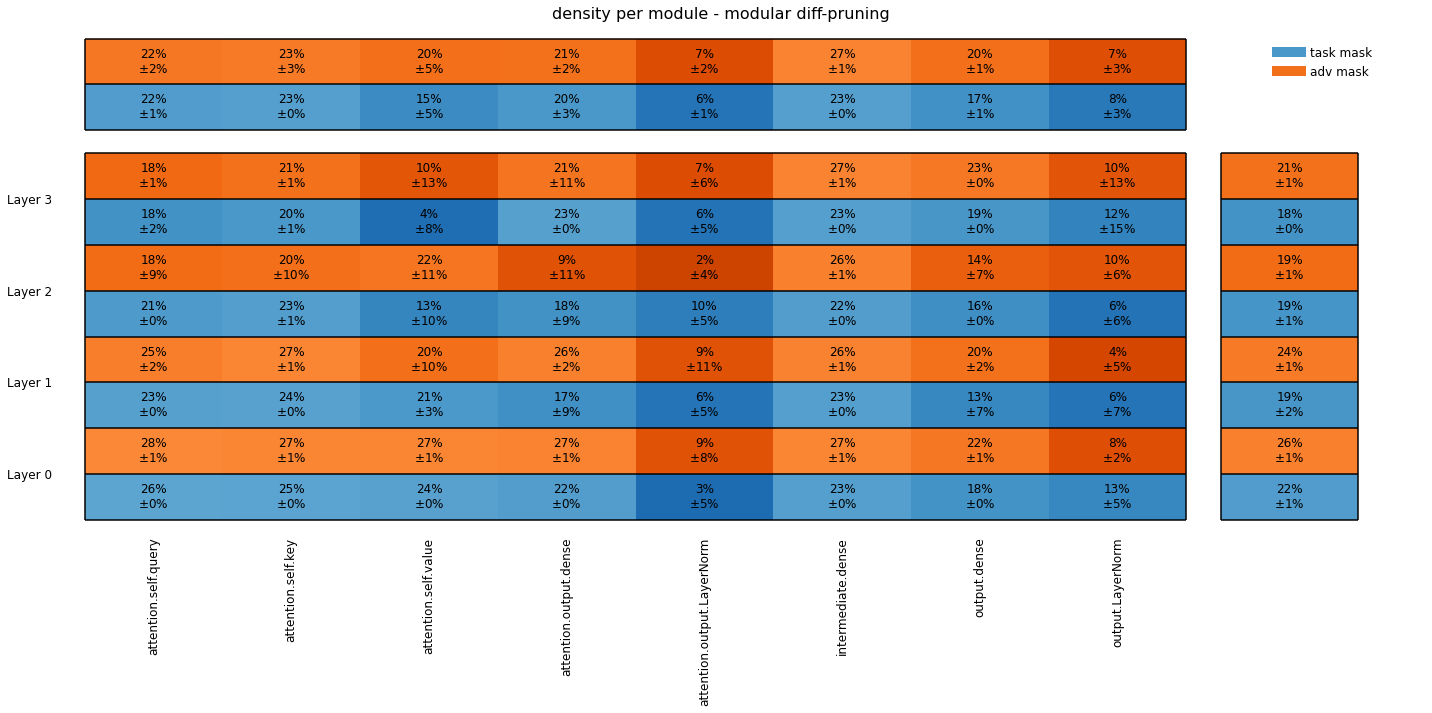

In [11]:
title_fontsize = 16
text_fontsize = 12

plt.figure(figsize=(20,10))
plt.barh(y_coords_adj, width/2, left=0-width/2, height=width, color="w")
start = 0
for m_name in module_names:
    averages, error_margins = [np.stack(x) for x in zip(*[l[m_name] for l in modular_layer_list])]
    m_averages, m_error_margins = modular_module_dict[m_name]
    color = [c(color_fn(a)) for avgs in averages for c, a in zip(colors, avgs)]

    color.append("w")
    color.extend([c(color_fn(a)) for c,a in zip(colors, m_averages)])

    plt.barh(y_coords_adj, width, height=width, left=start, color=color)
    for y, a, e in zip(y_coords, averages.flatten(), error_margins.flatten()):
        plt.text(start+width/2, y, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    for y, a, e in zip(y_coords_adj[-2:], m_averages, m_error_margins):
        plt.text(start+width/2, y, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

plt.barh(y_coords, spacing, left=start, height=width, color="w")
start += spacing

averages, error_margins = [np.stack(x) for x in zip(*list(modular_layer_dict.values())[1:])]
color = [c(color_fn(a)) for avgs in averages for c, a in zip(colors, avgs)]
plt.barh(y_coords, width, left=start, height=width, color=color)
for y, a, e in zip(y_coords, averages.flatten(), error_margins.flatten()):
    plt.text(start+width/2, y, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions[:-3]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0-width/2, y_coords[-1]+width/2, colors="black")
for x in vline_positions[:2]:
    plt.vlines(x, y_coords_adj[-2]-width/2, y_coords_adj[-1]+width/2, colors="black")

plt.xticks(np.arange(n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_tick_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)

plt.title("density per module - modular diff-pruning", fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-10)
plt.tick_params(axis="y", left=False, pad=-40)

custom_lines = [Line2D([0], [0], color=c(0.6), lw=10) for c in colors]
plt.legend(custom_lines, ["task mask", "adv mask"], bbox_to_anchor=(.97, .96), frameon=False, fontsize=text_fontsize)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "density_per_module_modular.png"))
plt.show()

In [12]:
n_modules = len(base_emb_dict)

width = 1
spacing = width / 4
x_coords = np.arange(n_modules, step=width)
x_coords_adj = np.concatenate([x_coords, [x_coords[-1]+spacing+width/2, x_coords[-1]+width*1.5]])
x_coords_lines = [x_coords[0]-width/2, x_coords[-1]+width/2, x_coords[-1]+width/2+spacing*2, x_coords[-1]+width*1.5+spacing*2]

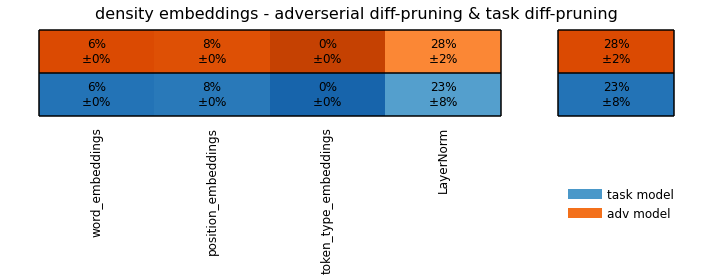

In [17]:
averages, error_margins= [np.stack(x, axis=1) for x in zip(*base_emb_dict.values())]
l_averages, l_error_margins = base_layer_dict[0]

plt.figure(figsize=(10,4))
for i, (avgs, errors, l_average, l_error) in enumerate(zip(averages, error_margins, l_averages, l_error_margins)):
    color = [colors[i](color_fn(a)) for a in avgs] + ["w", colors[i](color_fn(l_average))]
    plt.bar(x_coords_adj, height=width, width=[width] * n_modules + [spacing, width], bottom=i*width, color=color)
    for x, a, e in zip(x_coords, avgs, errors):
        plt.text(x, width/2 + i, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    plt.text(x_coords_adj[-1], width/2 + i, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in [0, width, width*2]:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, 0, width*2, colors="black")

plt.bar(0, height=-width/2, width=width, color="w")

plt.xticks(x_coords, labels=base_emb_dict.keys(), rotation=90, fontsize=text_fontsize)
plt.yticks([])
plt.title("density embeddings - adverserial diff-pruning & task diff-pruning", fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-20)

custom_lines = [Line2D([0], [0], color=c(0.6), lw=10) for c in colors]
plt.legend(custom_lines, ["task model", "adv model"], bbox_to_anchor=(.97, -0.3), frameon=False, fontsize=text_fontsize)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "density_embedding_baselines.png"))
plt.show()

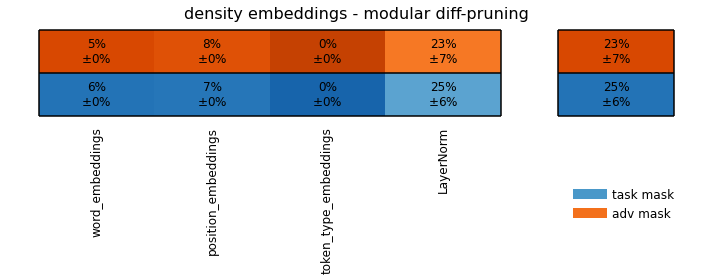

In [18]:
averages, error_margins= [np.stack(x, axis=1) for x in zip(*modular_emb_dict.values())]
l_averages, l_error_margins = modular_layer_dict[0]

plt.figure(figsize=(10,4))
for i, (avgs, errors, l_average, l_error) in enumerate(zip(averages, error_margins, l_averages, l_error_margins)):
    color = [colors[i](color_fn(a)) for a in avgs] + ["w", colors[i](color_fn(l_average))]
    plt.bar(x_coords_adj, height=width, width=[width] * n_modules + [spacing, width], bottom=i*width, color=color)
    for x, a, e in zip(x_coords, avgs, errors):
        plt.text(x, width/2 + i, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    plt.text(x_coords_adj[-1], width/2 + i, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in [0, width, width*2]:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, 0, width*2, colors="black")

plt.bar(0, height=-width/2, width=width, color="w")

plt.xticks(x_coords, labels=modular_emb_dict.keys(), rotation=90, fontsize=text_fontsize)
plt.yticks([])
plt.title("density embeddings - modular diff-pruning", fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-20)

custom_lines = [Line2D([0], [0], color=c(0.6), lw=10) for c in colors]
plt.legend(custom_lines, ["task mask", "adv mask"], bbox_to_anchor=(.97, -0.3), frameon=False, fontsize=text_fontsize)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "density_embedding_modular.png"))
plt.show()

### Single Model

In [31]:
model_idx = 1

layer_list = [{k:[v[model_idx] for v in vals] for k,vals in d.items()} for d in base_layer_list]
module_dict = {k:[v[model_idx] for v in vals] for k,vals in base_module_dict.items()}
layer_dict = {k:[v[model_idx] for v in vals] for k,vals in base_layer_dict.items()}
emb_dict = {k:[v[model_idx] for v in vals] for k,vals in base_emb_dict.items()}

In [21]:
n_layers = len(layer_list)
n_modules = len(layer_list[0])
module_names = list(layer_list[0].keys())

width = 1
spacing = width / 4
y_coords = np.arange(n_layers)
y_coords_adj = np.concatenate([
    y_coords,
    [y_coords[-1] + width, y_coords[-1] + width*1.5]]
)
hline_positions = np.concatenate([
    (y_coords - width/2),
    [y_coords[-1] + width/2, y_coords_adj[-1] - width/2, y_coords_adj[-1] + width/2]
])
vline_positions = [0, width*n_modules, width*n_modules+spacing, width*(n_modules+1)+spacing]

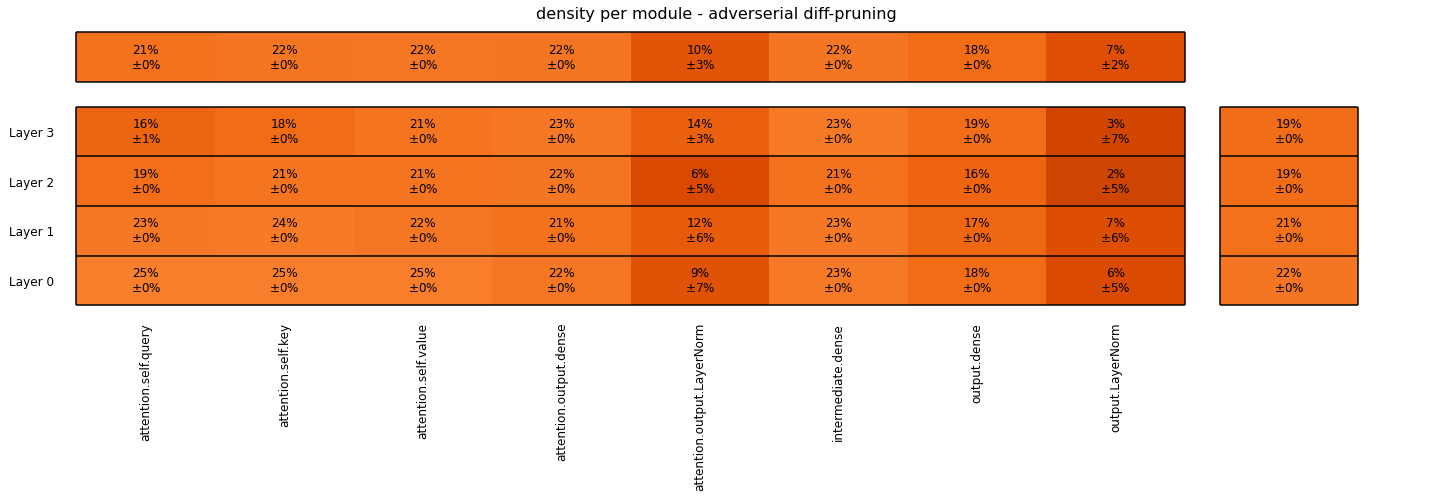

In [28]:
title_fontsize = 16
text_fontsize = 12
plt.figure(figsize=(20,7))
plt.barh(y_coords_adj, width/2, left=0-width/2, height=width, color="w")
start = 0
for m_name in module_names:
    averages, error_margins = zip(*[l[m_name] for l in layer_list])
    m_average, m_error_margin = module_dict[m_name]
    color = [colors[1](color_fn(a)) for a in averages]
    color.append("w")
    color.append(colors[1](color_fn(m_average)))
    plt.barh(y_coords_adj, width, height=width, left=start, color=color)
    for y, a, e in zip(y_coords, averages, error_margins):
        plt.text(start+width/2, y, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    plt.text(start+width/2, y_coords_adj[-1], "{:.0%}\n$\pm${:.0%}".format(m_average, m_error_margin), ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

plt.barh(y_coords, spacing, left=start, height=width, color="w")
start += spacing

averages, error_margins = zip(*list(layer_dict.values())[1:])
color = [colors[1](color_fn(a)) for a in averages]
plt.barh(y_coords, width, left=start, height=width, color=color)
for y, a, e in zip(y_coords, averages, error_margins):
    plt.text(start+width/2, y, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions[:-2]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0-width/2, y_coords[-1]+width/2, colors="black")
for x in vline_positions[:2]:
    plt.vlines(x, y_coords_adj[-1]-width/2, y_coords_adj[-1]+width/2, colors="black")

plt.xticks(np.arange(n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)
plt.title("density per module - adverserial diff-pruning", fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=0)
plt.tick_params(axis="y", left=False, pad=-50)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "density_per_module_adv.png"))
plt.show()

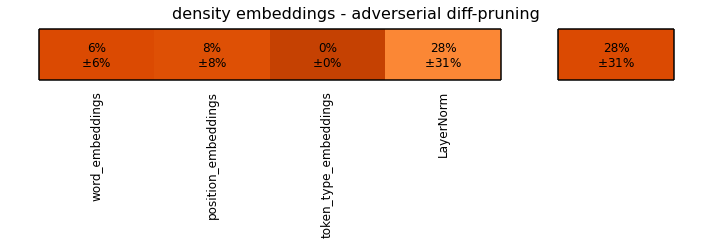

In [32]:
emb_dict = {k[11:]:v for k,v in model_dict.items() if k[:10]=="embeddings"}
n_modules = len(emb_dict)

width = 1
spacing = width / 4
x_coords = np.arange(n_modules, step=width)
x_coords_adj = np.concatenate([x_coords, [x_coords[-1]+spacing+width/2, x_coords[-1]+width*1.5]])
averages, error_margins= zip(*emb_dict.values())
l_average, l_error_margin = layer_dict[0]
color = [colors[1](color_fn(a)) for a in averages] + ["w", colors[1](color_fn(l_average))]
plt.figure(figsize=(10,3.5))
plt.bar(x_coords_adj, height=width, width=[width] * n_modules + [spacing, width], color=color)
for x, a, e in zip(x_coords, averages, error_margins):
    plt.text(x, width/2, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
plt.text(x_coords_adj[-1], width/2, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

x_coords_lines = [x_coords[0]-width/2, x_coords[-1]+width/2, x_coords[-1]+width/2+spacing*2, x_coords[-1]+width*1.5+spacing*2]
for y in [0, width]:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, 0, width, colors="black")

plt.bar(0, height=-width, width=width, color="w")

plt.xticks(x_coords, labels=emb_dict.keys(), rotation=90, fontsize=text_fontsize)
plt.yticks([])
plt.title("density embeddings - adverserial diff-pruning", fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-50)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "density_embedding_adv.png"))
plt.show()